# GMAC Optimization: Preliminary Analysis for evaluating the pitch and accl. magnitude estimation algoriths



### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [4]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
# deltaT = np.timedelta64(int(dT * 1e9), 'ns')

## Read the Controls and Patients Data

In [5]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

### Comparing pitch angle from th IMU and just the accelerometer

In [6]:
# Estimation pitch from the accelerometer data for all subjects.
left_pitch_hat = misc.computer_tilt_for_all_subjects(left, accl_lbl='ax', nwin=Fs + 1, causal=True)
right_pitch_hat = misc.computer_tilt_for_all_subjects(right, accl_lbl='ax', nwin=Fs + 1, causal=True)
aff_pitch_hat = misc.computer_tilt_for_all_subjects(aff, accl_lbl='ax', nwin=Fs + 1, causal=True)
unaff_pitch_hat = misc.computer_tilt_for_all_subjects(unaff, accl_lbl='ax', nwin=Fs + 1, causal=True)

### Plot of Pitch from IMU vs. Accelerometer [Healthy Subjects]

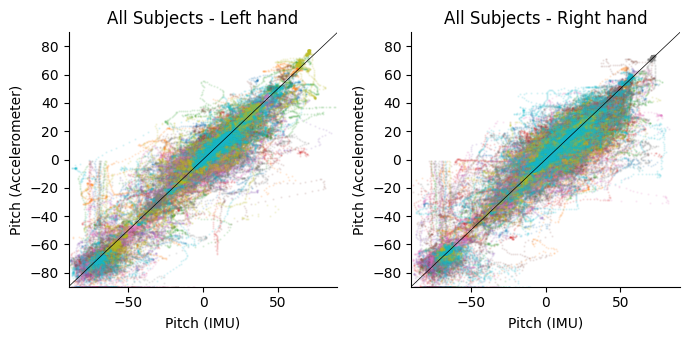

In [7]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in left.subject.unique():
    left_pitch = left[left.subject == _subj].pitch.values
    ax.scatter(left_pitch, left_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Left hand")
ax = fig.add_subplot(122)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in right.subject.unique():
    right_pitch = right[right.subject == _subj].pitch.values
    ax.scatter(right_pitch, right_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Right hand")
plt.tight_layout()

### Plot of Pitch from IMU vs. Accelerometer [Stroke Subjects]

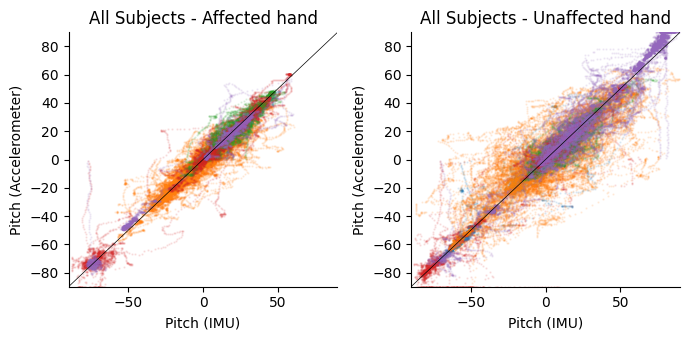

In [8]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in aff.subject.unique():
    aff_pitch = aff[aff.subject == _subj].pitch.values
    ax.scatter(aff_pitch, aff_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Affected hand")
ax = fig.add_subplot(122)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in unaff.subject.unique():
    unaff_pitch = unaff[unaff.subject == _subj].pitch.values
    ax.scatter(unaff_pitch, unaff_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Unaffected hand")
plt.tight_layout()

### Compute subjectwise Spearman correlation for pitch

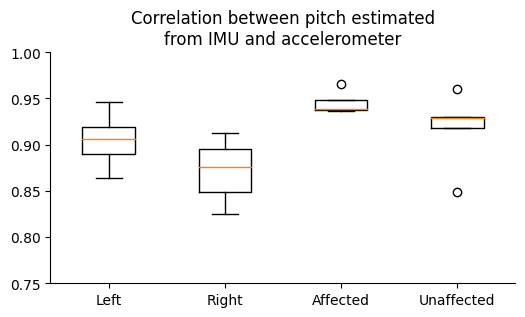

In [9]:
left_corr = [scipy.stats.spearmanr(left[left.subject == _subj].pitch.values,
                                   left_pitch_hat[_subj], nan_policy='omit').correlation
             for _subj in left.subject.unique()]
right_corr = [scipy.stats.spearmanr(right[right.subject == _subj].pitch.values,
                                    right_pitch_hat[_subj], nan_policy='omit').correlation
              for _subj in right.subject.unique()]
aff_corr = [scipy.stats.spearmanr(aff[aff.subject == _subj].pitch.values,
                                  aff_pitch_hat[_subj], nan_policy='omit').correlation for
            _subj in aff.subject.unique()]
unaff_corr = [scipy.stats.spearmanr(unaff[unaff.subject == _subj].pitch.values,
                                    unaff_pitch_hat[_subj], nan_policy='omit').correlation
              for _subj in unaff.subject.unique()]

# Plot the correlation values
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.boxplot([left_corr, right_corr, aff_corr, unaff_corr],
           labels=['Left', 'Right', 'Affected', 'Unaffected'])
ax.set_ylim(0.75, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Correlation between pitch estimated\nfrom IMU and accelerometer");

### Activity counts from IMU vs. Accelerometer

In [10]:
left_counts = {}
left_amag = {}
acc_lbls = ['ax', 'ay', 'az']
for _subj in left.subject.unique():
    df = left[left.subject==_subj]
    left_counts[_subj] = misc.compute_vector_magnitude(df)
    left_amag[_subj] = misc.compute_accl_magnitude(accl=df[acc_lbls].values,
                                                   time=df.index.values,
                                                   nfilt=5,
                                                   causal=True)
right_counts = {}
right_amag = {}
for _subj in right.subject.unique():
    df = right[right.subject==_subj]
    right_counts[_subj] = misc.compute_vector_magnitude(df)
    right_amag[_subj] = misc.compute_accl_magnitude(accl=df[acc_lbls].values,
                                                    time=df.index.values,
                                                    nfilt=5,
                                                    causal=True)
    
aff_counts = {}
aff_amag = {}
for _subj in aff.subject.unique():
    df = aff[aff.subject==_subj]
    aff_counts[_subj] = misc.compute_vector_magnitude(df)
    aff_amag[_subj] = misc.compute_accl_magnitude(accl=df[acc_lbls].values,
                                                  time=df.index.values,
                                                  nfilt=5,
                                                  causal=True)

unaff_counts = {}
unaff_amag = {}
for _subj in unaff.subject.unique():
    df = unaff[unaff.subject==_subj]
    unaff_counts[_subj] = misc.compute_vector_magnitude(df)
    unaff_amag[_subj] = misc.compute_accl_magnitude(accl=df[acc_lbls].values,
                                                    time=df.index.values,
                                                    nfilt=5,
                                                    causal=True)

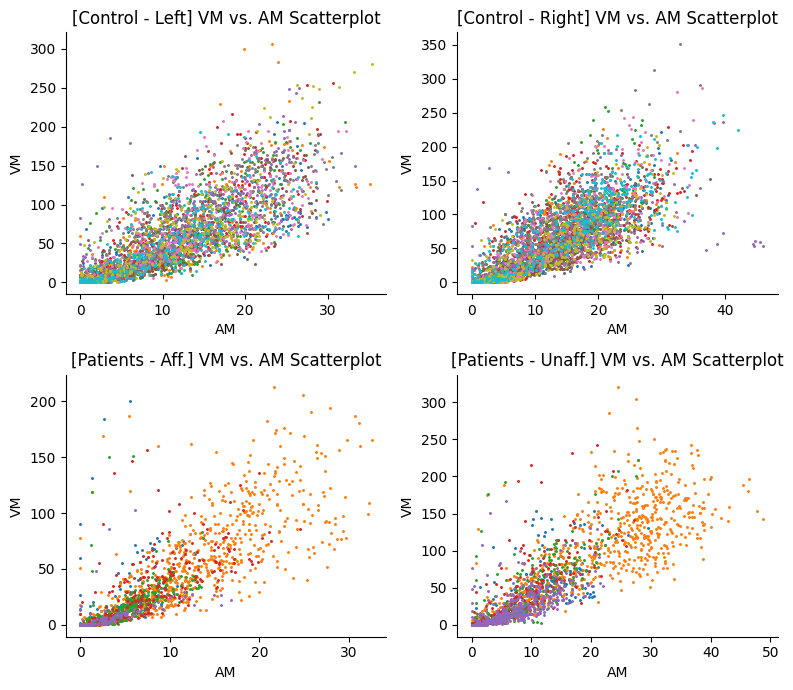

In [11]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(221)
for _subj in left.subject.unique():
    _combdf = pd.concat((left_counts[_subj]['counts'],
                         left_amag[_subj]['mag']), axis=1)
    ax.scatter(_combdf.mag.values, _combdf.counts.values, s=5, marker='.', alpha=1)

ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("[Control - Left] VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(222)
for _subj in right.subject.unique():
    _combdf = pd.concat((right_counts[_subj]['counts'],
                         right_amag[_subj]['mag']), axis=1)
    ax.scatter(_combdf.mag.values, _combdf.counts.values, s=5, marker='.', alpha=1)

ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("[Control - Right] VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(223)
for _subj in aff.subject.unique():
    _combdf = pd.concat((aff_counts[_subj]['counts'],
                         aff_amag[_subj]['mag']), axis=1)
    ax.scatter(_combdf.mag.values, _combdf.counts.values, s=5, marker='.', alpha=1)

ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("[Patients - Aff.] VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(224)
for _subj in unaff.subject.unique():
    _combdf = pd.concat((unaff_counts[_subj]['counts'],
                         unaff_amag[_subj]['mag']), axis=1)
    ax.scatter(_combdf.mag.values, _combdf.counts.values, s=5, marker='.', alpha=1)

ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("[Patients - Unaff.] VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

In [12]:
left_counts.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 1])

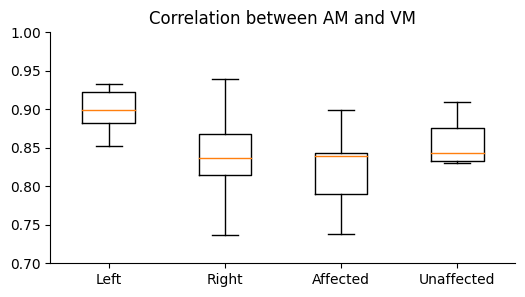

In [13]:
left_corr = []
for _subj in left.subject.unique():
    _combdf = pd.concat((left_counts[_subj]['counts'],
                         left_amag[_subj]['mag']), axis=1)
    left_corr.append(scipy.stats.spearmanr(_combdf.mag.values, _combdf.counts.values,
                                           nan_policy='omit').correlation)

right_corr = []
for _subj in right.subject.unique():
    _combdf = pd.concat((right_counts[_subj]['counts'],
                         right_amag[_subj]['mag']), axis=1)
    right_corr.append(scipy.stats.spearmanr(_combdf.mag.values, _combdf.counts.values,
                                            nan_policy='omit').correlation)

aff_corr = []
for _subj in aff.subject.unique():
    _combdf = pd.concat((aff_counts[_subj]['counts'],
                         aff_amag[_subj]['mag']), axis=1)
    aff_corr.append(scipy.stats.spearmanr(_combdf.mag.values, _combdf.counts.values,
                                          nan_policy='omit').correlation)

unaff_corr = []
for _subj in unaff.subject.unique():
    _combdf = pd.concat((unaff_counts[_subj]['counts'],
                         unaff_amag[_subj]['mag']), axis=1)
    unaff_corr.append(scipy.stats.spearmanr(_combdf.mag.values, _combdf.counts.values,
                                            nan_policy='omit').correlation)

# Plot the correlation values
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.boxplot([left_corr, right_corr, aff_corr, unaff_corr],
           labels=['Left', 'Right', 'Affected', 'Unaffected'])
ax.set_ylim(0.7, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Correlation between AM and VM");

## Single Subject Analayis

In [16]:
subj = 1
df = right[right.subject==subj]
act_counts = misc.compute_vector_magnitude(df)
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0
amag = misc.compute_accl_magnitude(df[['ax', 'ay', 'az']].values,
                                   time=df.index.values,
                                   nfilt=5,
                                   causal=True)

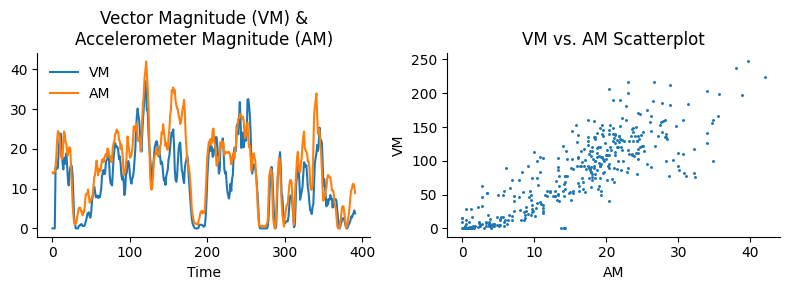

In [25]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax.plot(0.15 * counts, label="VM")
ax.plot(amag.mag.values, label="AM")
ax.set_xlabel("Time")
ax.set_title("Vector Magnitude (VM) &\nAccelerometer Magnitude (AM)")
ax.legend(loc=2, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax = fig.add_subplot(122)
ax.scatter(amag.mag.values, counts, s=5, marker='.', alpha=1)
ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

# GMAC

In [36]:
gmac = [1 if np.abs(pitch) < 30 and count > 0 else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):50], amag)]
gnd = [r[r.subject==1].gnd[i] for i in range(0, len(r[r.subject==1]), 50)]

In [41]:
ca.confmatrix(gmac, gnd)

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.58312,0.120205,0.16624,0.130435,0.713555,0.524543,0.778157,0.520408,0.829091,0.802817,0.649283


In [33]:
gmac_original = (ca.get_gm_modified(r[r.subject==1])).pred.values

In [42]:
ca.confmatrix(gmac_original, gnd[1:])

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.54359,0.110256,0.207692,0.138462,0.682051,0.453757,0.723549,0.556701,0.831373,0.773723,0.640125


# optimizing parameters 

In [ ]:
def compute_gmac(ax, ay, az, freq=50, pitch_threshold=30, counts_threshold=0, hpf_cutoff=1, pitch_window=1, counts_window=5):
  w = pitch_window*round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  pitch = -np.rad2deg(np.arccos(ax))+90

  b, a = signal.butter(2, hpf_cutoff/(2*freq), 'high')
  ax_filt = signal.filtfilt(b, a, ax)
  ay_filt = signal.filtfilt(b, a, ay)
  az_filt = signal.filtfilt(b, a, az)

  deadband_threshold = 0.068
  ax_filt[np.abs(ax_filt)<deadband_threshold] = 0
  ay_filt[np.abs(ay_filt)<deadband_threshold] = 0
  az_filt[np.abs(az_filt)<deadband_threshold] = 0

  amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
  amag = [sum(amag[i:i+freq]) for i in range(0, len(amag), freq)]
  w = counts_window
  amag = np.append(np.ones(w-1)*amag[0], amag)

  # moving average filter
  amag = np.convolve(amag, np.ones(w), 'valid') / w

  gmac = [1 if np.abs(pitch) < pitch_threshold and count > counts_threshold else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):freq], amag)]
  return gmac